In [ ]:
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import timeit
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd

Loading the data

In [ ]:
def data_init():
    URL = {
        'train': "https://raw.githubusercontent.com/Nadavmarci/DataScience/master/ptb.train.txt",
        'test': "https://raw.githubusercontent.com/Nadavmarci/DataScience/master/ptb.test.txt",
        'valid': "https://raw.githubusercontent.com/Nadavmarci/DataScience/master/ptb.valid.txt",
    }
    with urllib.request.urlopen(URL['train']) as f:
        file = f.read().decode('utf-8')
        trn = file[1:].split(' ')
    with urllib.request.urlopen(URL['valid']) as f:
        file = f.read().decode('utf-8')
        vld = file[1:].split(' ')
    with urllib.request.urlopen(URL['test']) as f:
        file = f.read().decode('utf-8')
        tst = file[1:].split(' ')
    words = sorted(set(trn))
    char2ind = {c: i for i, c in enumerate(words)}
    trn = [char2ind[c] for c in trn]
    vld = [char2ind[c] for c in vld]
    tst = [char2ind[c] for c in tst]
    return np.array(trn).reshape(-1, 1), np.array(vld).reshape(-1, 1), np.array(tst).reshape(-1, 1), len(words)

First checking if GPU is available

In [ ]:
train_on_gpu=torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU.')
    torch.device('cuda')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [ ]:
batch_size = 20
hidden_size = 200
layer_num = 2

class Model(nn.Module):
    def __init__(self, vocab_size, hidden_size, layer_num, dropout, winit, rnn_type):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.layer_num = layer_num
        self.winit = winit
        self.embed = Embed(vocab_size, hidden_size)
        self.rnn_type = rnn_type
        if rnn_type == 'GRU':
            self.rnns = [nn.GRU(hidden_size, hidden_size) for i in range(layer_num)]
        else:
            self.rnns = [nn.LSTM(hidden_size, hidden_size) for i in range(layer_num)]
        self.rnns = nn.ModuleList(self.rnns)
        self.fc = Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(p=dropout)
        self.reset_parameters()

    def reset_parameters(self):
        for param in self.parameters():
            nn.init.uniform_(param, -self.winit, self.winit)

    def state_init(self, batch_size,rnn_type):
        dev = next(self.parameters()).device
        if rnn_type == 'LSTM':
            states = [(torch.zeros(1, batch_size, layer.hidden_size, device = dev), torch.zeros(1, batch_size, layer.hidden_size, device = dev)) for layer in self.rnns]
        else:
            states = [(torch.zeros(1, batch_size, layer.hidden_size, device = dev)) for layer in self.rnns]
        return states

    def detach(self, states,rnn_type):
        if rnn_type =='GRU':
            return [h.detach() for h in states]
        else:
            return [(h.detach(), c.detach()) for (h,c) in states]

    def forward(self, x, states):
        x = self.embed(x)
        x = self.dropout(x)
        for i, rnn in enumerate(self.rnns):
            x, states[i] = rnn(x, states[i])
            x = self.dropout(x)
        scores = self.fc(x)
        return scores, states

In [ ]:
def minibatch(data, batch_size, seq_length):
    data = torch.tensor(data, dtype = torch.int64)
    num_batches = data.size(0)//batch_size
    data = data[:num_batches*batch_size]
    data=data.view(batch_size,-1)
    dataset = []
    for i in range(0,data.size(1)-1,seq_length):
        seqlen=int(np.min([seq_length,data.size(1)-1-i]))
        if seqlen<data.size(1)-1-i:
            x=data[:,i:i+seqlen].transpose(1, 0)
            y=data[:,i+1:i+seqlen+1].transpose(1, 0)
            dataset.append((x, y))
    return dataset

class Linear(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.b = nn.Parameter(torch.Tensor(hidden_size))

    def forward(self, x):
        z = torch.addmm(self.b, x.view(-1, x.size(2)), self.W.t())
        return z

    def __repr__(self):
        return "FC(input: {}, output: {})".format(self.input_size, self.hidden_size)

class Embed(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.W = nn.Parameter(torch.Tensor(vocab_size, embed_size))

    def forward(self, x):
        return self.W[x]

    def __repr__(self):
        return "Embedding(vocab: {}, embedding: {})".format(self.vocab_size, self.embed_size)

In [ ]:
def nll_loss(scores, y):
    batch_size = y.size(1)
    expscores = scores.exp()
    probabilities = expscores / expscores.sum(1, keepdim = True)
    answerprobs = probabilities[range(len(y.reshape(-1))), y.reshape(-1)]
    return torch.mean(-torch.log(answerprobs) * batch_size)

def perplexity(data, model,rnn_type):
    with torch.no_grad():
        losses = []
        states = model.state_init(batch_size,rnn_type)
        for x, y in data:
            scores, states = model(x, states)
            loss = nll_loss(scores, y)
            losses.append(loss.data.item()/batch_size)
    return np.exp(np.mean(losses))

In [ ]:
def train(data, model, epochs, epoch_threshold, lr, factor, max_norm,rnn_type):
    train_data, validation_data, test_data = data
    tic = timeit.default_timer()
    total_words = 0
    train_perplexity = []
    test_perplexity = []
    valid_perp_min = np.Inf

    print("Starting training.\n")
    for epoch in range(epochs):
        states = model.state_init(batch_size,rnn_type)
        model.train()
        if epoch > epoch_threshold:
            lr = lr / factor
        for i, (x, y) in enumerate(train_data):
            total_words += x.numel()
            model.zero_grad()
            states = model.detach(states,rnn_type)
            scores, states = model(x, states)
            loss = nll_loss(scores, y)
            loss.backward()
            
            
            with torch.no_grad():
                norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm)
                for param in model.parameters():
                    param -= lr * param.grad

            if i % (len(train_data)//10) == 0:
                toc = timeit.default_timer()

                print("batch no = {:d} / {:d}, ".format(i, len(train_data)) +
                      "train loss = {:.3f}, ".format(loss.item()/batch_size) +
                      "lr = {:.3f}, ".format(lr) +
                      "since beginning = {:d} mins, ".format(round((toc-tic)/60)) 
                      )
        model.eval()
        val_perp = perplexity(validation_data, model,rnn_type)

        if val_perp <= valid_perp_min:
            torch.save(model.state_dict(), 'model_cifar.pt')
            valid_perp_min = val_perp

        epoch_train_perplexity = perplexity(train_data, model, rnn_type)
        epoch_test_perplexity = perplexity(test_data, model, rnn_type)
        train_perplexity.append(epoch_train_perplexity)
        test_perplexity.append(epoch_test_perplexity)
        print("Epoch : {:d} || Validation set perplexity : {:.3f}".format(epoch+1, val_perp))
        print("*************************************************\n")
    model.load_state_dict(torch.load('model_cifar.pt'))
    tst_perp = perplexity(test_data, model,rnn_type)
    print("validation preplexity : {:.3f}".format(val_perp))
    print("Training is over.")
    return train_perplexity, test_perplexity, val_perp

In [ ]:
def plot_convergence(n_epochs, test_perplexity, train_perplexity, title):
    plt.plot(range(n_epochs), test_perplexity, label = "Test")
    plt.plot(range(n_epochs), train_perplexity, label = "Train")
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def test_model(dropout,rnn_type, total_epochs,learning_rate,winit,seq_length,factor_epoch,factor,max_grad_norm, title):
    trn, vld, tst, vocab_size = data_init()
    trn = minibatch(trn, batch_size, seq_length)
    vld = minibatch(vld, batch_size, seq_length)
    tst = minibatch(tst, batch_size, seq_length)
    model = Model(vocab_size, hidden_size, layer_num, dropout, winit, rnn_type)
    if torch.cuda.is_available(): model.to("cuda") 
    else: model.to("cpu")
    final_title = title 
    train_perplexity, test_perplexity,validation_preplexity = train((trn, vld, tst), model, total_epochs, factor_epoch, learning_rate, factor, max_grad_norm,rnn_type)
    plot_convergence(total_epochs, test_perplexity, train_perplexity, final_title)
    return (perplexity(tst,model,rnn_type), perplexity(trn,model,rnn_type), validation_preplexity), final_title

# **LSTM:**

LSTM without droput

Starting training.

batch no = 0 / 1327, train loss = 9.212, lr = 0.950, since beginning = 0 mins, 
batch no = 132 / 1327, train loss = 6.699, lr = 0.950, since beginning = 0 mins, 
batch no = 264 / 1327, train loss = 6.402, lr = 0.950, since beginning = 0 mins, 
batch no = 396 / 1327, train loss = 6.372, lr = 0.950, since beginning = 0 mins, 
batch no = 528 / 1327, train loss = 6.109, lr = 0.950, since beginning = 0 mins, 
batch no = 660 / 1327, train loss = 5.896, lr = 0.950, since beginning = 0 mins, 
batch no = 792 / 1327, train loss = 5.742, lr = 0.950, since beginning = 0 mins, 
batch no = 924 / 1327, train loss = 5.439, lr = 0.950, since beginning = 0 mins, 
batch no = 1056 / 1327, train loss = 5.683, lr = 0.950, since beginning = 0 mins, 
batch no = 1188 / 1327, train loss = 5.203, lr = 0.950, since beginning = 0 mins, 
batch no = 1320 / 1327, train loss = 5.647, lr = 0.950, since beginning = 0 mins, 
Epoch : 1 || Validation set perplexity : 240.490
****************************

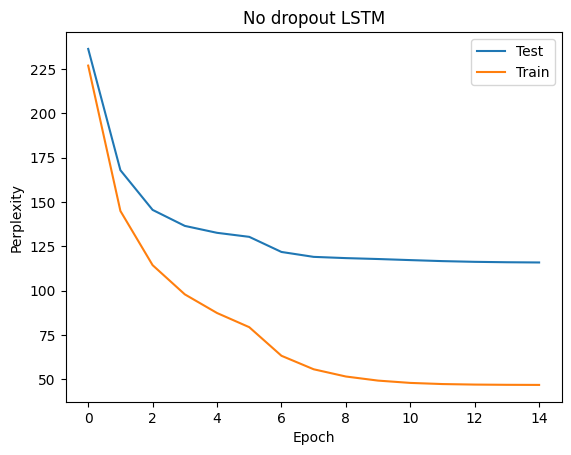

In [ ]:
LSTM_NoDrop = test_model(dropout=0,rnn_type='LSTM', total_epochs=15,learning_rate=0.95,winit=0.05,seq_length=35,factor_epoch=5,factor=2,max_grad_norm=5, title="No dropout LSTM")

LSTM with dropout

Starting training.

batch no = 0 / 1327, train loss = 9.212, lr = 0.220, since beginning = 0 mins, 
batch no = 132 / 1327, train loss = 6.817, lr = 0.220, since beginning = 0 mins, 
batch no = 264 / 1327, train loss = 6.700, lr = 0.220, since beginning = 0 mins, 
batch no = 396 / 1327, train loss = 6.635, lr = 0.220, since beginning = 0 mins, 
batch no = 528 / 1327, train loss = 6.763, lr = 0.220, since beginning = 0 mins, 
batch no = 660 / 1327, train loss = 6.674, lr = 0.220, since beginning = 0 mins, 
batch no = 792 / 1327, train loss = 6.439, lr = 0.220, since beginning = 0 mins, 
batch no = 924 / 1327, train loss = 6.185, lr = 0.220, since beginning = 0 mins, 
batch no = 1056 / 1327, train loss = 6.450, lr = 0.220, since beginning = 0 mins, 
batch no = 1188 / 1327, train loss = 6.011, lr = 0.220, since beginning = 0 mins, 
batch no = 1320 / 1327, train loss = 6.301, lr = 0.220, since beginning = 0 mins, 
Epoch : 1 || Validation set perplexity : 485.088
****************************

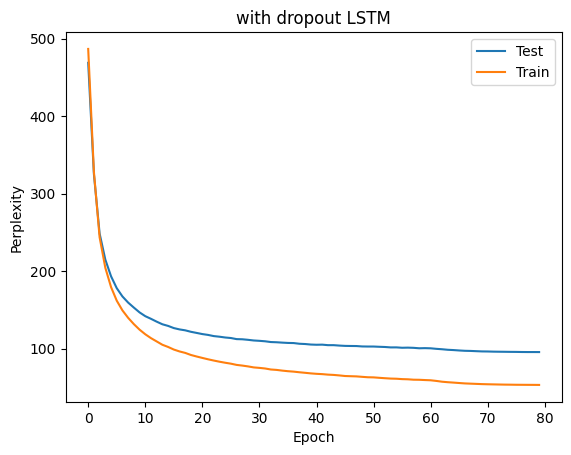

In [ ]:
LSTM_Drop = test_model(dropout=0.5, rnn_type='LSTM',total_epochs=80, learning_rate=0.22,winit=0.05,seq_length=35,factor_epoch=60,factor=1.2,max_grad_norm=5, title="with dropout LSTM")

# **GRU:**

GRU without dropout

Starting training.

batch no = 0 / 1327, train loss = 9.209, lr = 0.380, since beginning = 0 mins, 
batch no = 132 / 1327, train loss = 6.953, lr = 0.380, since beginning = 0 mins, 
batch no = 264 / 1327, train loss = 6.664, lr = 0.380, since beginning = 0 mins, 
batch no = 396 / 1327, train loss = 6.337, lr = 0.380, since beginning = 0 mins, 
batch no = 528 / 1327, train loss = 6.281, lr = 0.380, since beginning = 0 mins, 
batch no = 660 / 1327, train loss = 5.939, lr = 0.380, since beginning = 0 mins, 
batch no = 792 / 1327, train loss = 5.823, lr = 0.380, since beginning = 0 mins, 
batch no = 924 / 1327, train loss = 5.459, lr = 0.380, since beginning = 0 mins, 
batch no = 1056 / 1327, train loss = 5.865, lr = 0.380, since beginning = 0 mins, 
batch no = 1188 / 1327, train loss = 5.332, lr = 0.380, since beginning = 0 mins, 
batch no = 1320 / 1327, train loss = 5.713, lr = 0.380, since beginning = 0 mins, 
Epoch : 1 || Validation set perplexity : 271.258
****************************

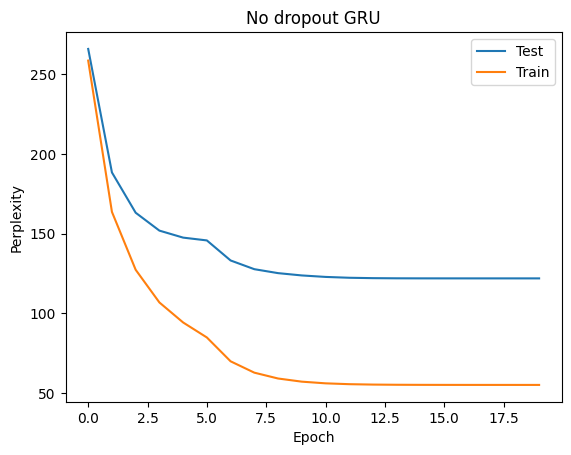

In [ ]:
GRU_NoDrop = test_model(dropout=0,rnn_type='GRU',total_epochs=20, learning_rate=0.38,winit=0.05,seq_length=35,factor_epoch=5,factor=2,max_grad_norm=5,title="No dropout GRU")

GRU with dropout

Starting training.

batch no = 0 / 1256, train loss = 9.209, lr = 0.300, since beginning = 0 mins, 
batch no = 125 / 1256, train loss = 6.882, lr = 0.300, since beginning = 0 mins, 
batch no = 250 / 1256, train loss = 6.461, lr = 0.300, since beginning = 0 mins, 
batch no = 375 / 1256, train loss = 6.428, lr = 0.300, since beginning = 0 mins, 
batch no = 500 / 1256, train loss = 6.348, lr = 0.300, since beginning = 0 mins, 
batch no = 625 / 1256, train loss = 6.097, lr = 0.300, since beginning = 0 mins, 
batch no = 750 / 1256, train loss = 6.092, lr = 0.300, since beginning = 0 mins, 
batch no = 875 / 1256, train loss = 6.115, lr = 0.300, since beginning = 0 mins, 
batch no = 1000 / 1256, train loss = 5.945, lr = 0.300, since beginning = 0 mins, 
batch no = 1125 / 1256, train loss = 5.642, lr = 0.300, since beginning = 0 mins, 
batch no = 1250 / 1256, train loss = 5.919, lr = 0.300, since beginning = 0 mins, 
Epoch : 1 || Validation set perplexity : 300.843
****************************

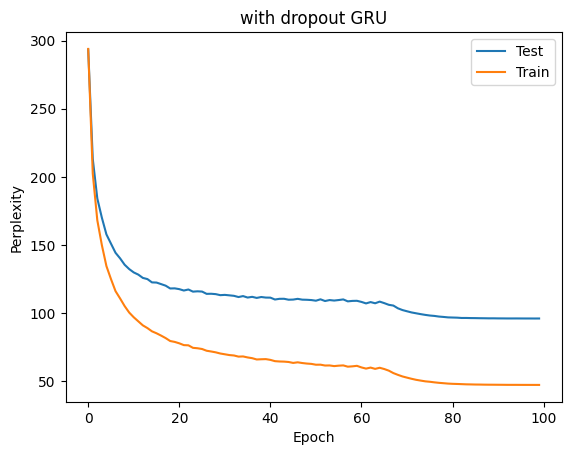

In [ ]:
GRU_Drop = test_model(dropout=0.5, rnn_type='GRU', total_epochs=100, learning_rate=0.29995,winit=0.05,seq_length=37,factor_epoch=65,factor=1.21,max_grad_norm=6, title="with dropout GRU")

In [ ]:
data = {'Test Perplexity': [LSTM_NoDrop[0][0],LSTM_Drop[0][0],GRU_NoDrop[0][0],GRU_Drop[0][0]],
        'Train Perplexity': [LSTM_NoDrop[0][1],LSTM_Drop[0][1],GRU_NoDrop[0][1],GRU_Drop[0][1]],
        'Validation Perplexity': [LSTM_NoDrop[0][2],LSTM_Drop[0][2],GRU_NoDrop[0][2],GRU_Drop[0][2]]}
df_summary = pd.DataFrame(data, index=['LSTM no dropout','LSTM with dropout','GRU no dropout','GRU with dropout'])
df_summary

,Test Perplexity,Train Perplexity,Validation Perplexity
LSTM no dropout,115.855228,46.708482,120.067959
LSTM with dropout,95.384378,52.967995,99.107639
GRU no dropout,121.869505,55.048303,124.936015
GRU with dropout,96.172653,47.474728,99.981398
